# Stock trading pattern test

Simulation of a trading pattern (on a Chinese stock).

Average profit rate of this trading pattern will be calculated.

Visualization available.

-- GongChen'xi

  20220111

In [1]:
# parameters
stock_num = 'sh.600000'
start_date = '2019-01-01'
end_date = '2021-12-31'

In [2]:
import baostock as bs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def fetch_info(stock_num, info, start_date, end_date):
    bs.login()
    rs = bs.query_history_k_data_plus(stock_num, info,
        start_date = start_date, end_date = end_date,
        frequency="d", adjustflag="3")
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    bs.logout()
    return data_list

In [4]:
# make dictionary of RSI6, RSI24
rsi6 = {}
rsi24 = {}
change = fetch_info(stock_num, 'date, pctChg', start_date, end_date)

for i in range(len(change)):
    if i >= 23:
        date = change[i][0]
        
        # RSI6
        try:
            denominator = 0
            numerator = 0
            for j in range(6):
                denominator += abs(float(change[i-j][1]))
                if float(change[i-j][1]) > 0:
                    numerator += abs(float(change[i-j][1]))
            rsi6[date] = numerator/denominator
        except:
            rsi6[date] = 0.0
            
        # RSI24
        try:
            denominator = 0
            numerator = 0
            for j in range(24):
                denominator += abs(float(change[i-j][1]))
                if float(change[i-j][1]) > 0:
                    numerator += abs(float(change[i-j][1]))
            rsi24[date] = numerator/denominator
        except:
            rsi24[date] = 0.0

login success!
logout success!


In [5]:
# make dictionary of close price
close_price = {}
close = fetch_info(stock_num, 'date, close', start_date, end_date)

for i in range(len(close)):
    close_price[close[i][0]] = float(close[i][1])

login success!
logout success!


In [6]:
# make list of trading dates
trading_date_list = []
date = fetch_info(stock_num, 'date', start_date, end_date)
for i in range(len(date)):
    trading_date_list.append(date[i][0])

login success!
logout success!


In [7]:
def change_rate(buy_date, date):
    buy_price = close_price[buy_date]
    current_price = close_price[date]
    change = (current_price-buy_price)/buy_price
    return change

def buy_signal(date):
    buy = 1
    # RSI24  < 30 and
    if rsi24[date] >= 0.3:
        buy = 0
    # RSI6 < 50 and
    if rsi6[date] >= 0.5:
        buy = 0
    # RSI6 - RSI24 > 0.5
    if rsi6[date] - rsi24[date] <= 0.05:
        buy = 0
    return buy

def sell_signal(buy_date, date):
    sell = 0
    # loss = 5% or
    if change_rate(buy_date, date) < -0.05:
        sell = 1
    # profit = 10% or
    if change_rate(buy_date, date) > 0.1:
        sell = 1
    # RSI6 > 75 or
    if rsi6[date] > 0.75:
        sell = 1
    # RSI24 > 60 or
    if rsi24[date] > 0.60:
        sell = 1
    # RSI6 - RSI24 < 0
    if rsi6[date] - rsi24[date] < 0.0:
        sell = 1
    return sell

def simulation_start_date():
    date = trading_date_list[23]
    return date

def next_date(date):
    new_date = None
    for i in range(len(trading_date_list)):
        if trading_date_list[i] == date:
            new_date = trading_date_list[i+1]
    return new_date

In [8]:
# simulation
position = 0 # 1 for stock, 0 for cash
date = simulation_start_date()
record = []
buy_date = None

while True:
    if position == 0:
        if buy_signal(date) == 1:
            # all in
            position = 1
            buy_date = date
            # record behavior
            record.append((date, 'buy'))
        else:
            # stand
            pass
    else:
        if sell_signal(buy_date, date) == 1:
            # sell all
            position = 0
            # record behavior
            record.append((date, 'sell'))
        else:
            # stand
            pass
    if date == end_date:
        break
    # move to next trading day
    date = next_date(date)

         date action  close
0  2019-12-05    buy  11.89
1  2019-12-17   sell  12.39
2  2020-09-18    buy   9.94
3  2020-09-28   sell   9.46
4  2021-10-25    buy   9.03
5  2021-10-28   sell   8.96
6  2021-11-10    buy   8.48
7  2021-11-15   sell   8.75

Average yield on this pattern of trading:  0.0044625227214519225


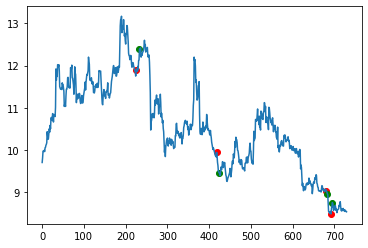

In [9]:
# trade record
close = []
date = []
for i in close_price:
    close.append(close_price[i])
    date.append(i)
t = []
for i in range(len(close)):
    t.append(i)
plt.plot(t, close)

buy_price = []
buy_t = []
sell_price = []
sell_t = []
for i in record:
    for j in range(len(date)):
        if date[j] == i[0]:
            if i[1] == 'buy':
                buy_price.append(close_price[date[j]])
                buy_t.append(j)
            if i[1] == 'sell':
                sell_price.append(close_price[date[j]])
                sell_t.append(j)
plt.scatter(buy_t, buy_price, color = 'red')
plt.scatter(sell_t, sell_price, color = 'green')

trade_list = []
for i in record:
    for j in range(len(date)):
        if date[j] == i[0]:
            trade_list.append([i[0], i[1], close_price[date[j]]])
trade = pd.DataFrame(trade_list, columns = ['date', 'action', 'close'])
print(trade, end = '\n\n')

profit = []
if len(trade_list) % 2 == 1:
    trade_list.pop()
for i in range(int(len(trade_list)/2)):
    profit.append((trade_list[2*i+1][2] - trade_list[2*i][2])/trade_list[2*i][2])
profit = np.array(profit)
average = profit.mean()
print('Average yield on this pattern of trading: ', average)